epoch: 0, loss: 0.7389784124931654
epoch: 500, loss: 0.003353661536116659
epoch: 1000, loss: 4.613122392968516e-05
tensor([0.5033+2.7756e-17j, 0.5006-3.9578e-03j, 0.4959-1.0921e-03j,
        0.5001+1.9983e-03j], dtype=torch.complex128, grad_fn=<MulBackward0>)


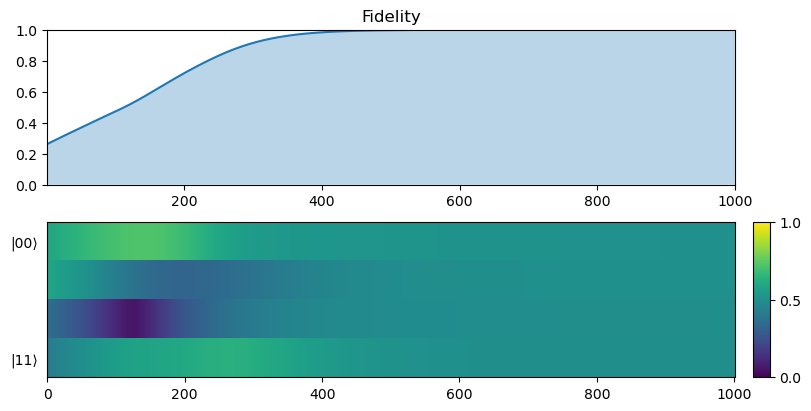

In [178]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

num_epochs = 1001

learning_rate = 1e-3

num_layers = 5

n_qft_qubits = 2

N = 2**n_qft_qubits
n_train_qubits = N

batch_size = N

loss_graph = []

q_graph = np.zeros((2**n_qft_qubits,num_epochs))


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n_qft_qubits
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(n_train_qubits):
            basis = torch.zeros(n_train_qubits, dtype=torch.complex128)
            basis[i] = 1
            dataset.append(basis)
            labels.append(F @ basis)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        q0 = torch.tensor([1,0], dtype=torch.complex128, requires_grad=False)   
        
        if len(x.shape) == 1:
            x = basis(x)
            for layer in range(num_layers):
                    for a in range(n_qft_qubits // 2):
                        x = cz(2*a,2*a+1) @ x
                    for b in range(n_qft_qubits):
                        x = U(b,layer) @ x
                    for c in range((n_qft_qubits-1)//2):
                        x = cz(2*c+1,2*c+2) @ x
            return x
        else:
            x_out = []
            for x in batch:
                for layer in range(num_layers):
                    for a in range(n_qft_qubits // 2):
                        x = cz(2*a,2*a+1) @ x
                    for b in range(n_qft_qubits):
                        x = U(b,layer) @ x
                    for c in range((n_qft_qubits-1)//2):
                        x = cz(2*c+1,2*c+2) @ x
                x_out.append(x)
                x_graph = abs(x)
            
            for i in range(2**n_qft_qubits):
                q_graph[i][epoch] = x_graph[i]
            
                
            return torch.stack(x_out)

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_qft_qubits], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(N), 1])

axis_ones = ""
for i in range(n_qft_qubits):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_qft_qubits):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_qft_qubits - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

In [189]:
new_basis = torch.eye(N)
new_out = model(new_basis)
print(new_out)
for i in range(len(new_out)):
    fake_global_phase = torch.angle(new_out[i][0])
    new_out[i] = torch.exp(-1j * fake_global_phase) * new_out[i]
new_out = new_out.detach().numpy()
print(new_out)

tensor([[-0.2301-0.4476j, -0.2323-0.4434j, -0.2277-0.4406j, -0.2268-0.4457j],
        [-0.3797-0.3212j, -0.3194+0.3834j,  0.3850+0.3249j,  0.3253-0.3797j],
        [-0.0441-0.4951j,  0.0405+0.4971j, -0.0424-0.5018j,  0.0467+0.4983j],
        [ 0.0701+0.4974j, -0.4974+0.0657j, -0.0676-0.4920j,  0.4941-0.0724j]],
       dtype=torch.complex128, grad_fn=<StackBackward0>)
[[ 0.50329344+2.77555756e-17j  0.50060082-3.95780587e-03j
   0.49593837-1.09208302e-03j  0.5001188 +1.99833356e-03j]
 [ 0.49731147+2.77555756e-17j -0.003781  -4.98944597e-01j
  -0.50373744+5.87992180e-04j -0.00310181+4.99959917e-01j]
 [ 0.49709573+2.77555756e-17j -0.49869981-3.73766715e-03j
   0.50363061+2.24296493e-03j -0.50052567+2.36391876e-03j]
 [ 0.50226771+1.38777878e-17j -0.00431488+5.01686216e-01j
  -0.49662908-1.70774532e-03j -0.00269731-4.99368440e-01j]]


In [190]:
def hinton_square(x,y,U_angle,U_angle_min, U_angle_max,area,cmap=None,ax=None):
    
    h = np.sqrt(area) / 2
    color = (U_angle - U_angle_min) / (U_angle_max - U_angle_min)
    
    x = np.array([x - h, x + h, x + h, x - h])
    y = np.array([y - h, y - h, y + h, y + h])
    
    plt.fill(x,y, color=cmap(color))

In [191]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def hinton(U):
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))
    
    height, width = U.shape
    
    ax.axis('equal')
    ax.set_frame_on(False)
    plt.xlim(0,width)
    plt.ylim(0,height)

    U_max = np.max(np.abs(U))
    
    cmap = plt.get_cmap('twilight')
    scale = 0.8

    
    for i in range(width):
        for j in range(height):
            x = i + 0.5
            y = j + 0.5
            hinton_square(x, height - y, np.angle(U[i,j]), -np.pi, np.pi, 
                          np.abs(U[i,j]) / U_max * scale, cmap=cmap, ax=ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '4%', pad = '2%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(-np.pi, np.pi),
                                     ticks = [])

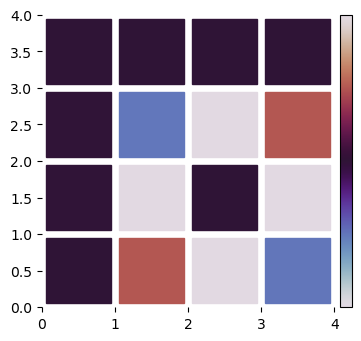

In [192]:
hinton(new_out)

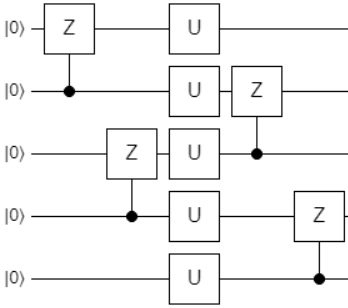

epoch: 0, loss: 0.9048207000294759
epoch: 500, loss: 0.17797675256660317
epoch: 1000, loss: 0.1342227401364116
tensor([0.1412+1.3878e-17j, 0.1944+3.6674e-02j, 0.1029+1.5961e-02j,
        0.1433+4.5912e-02j, 0.1422+4.1054e-02j, 0.2197-5.8074e-02j,
        0.1501+1.2783e-02j, 0.1725+2.1785e-02j, 0.1409+1.3751e-02j,
        0.1896+1.1878e-02j, 0.1392-5.4516e-02j, 0.1444-3.1390e-02j,
        0.1713+7.9190e-03j, 0.1333+2.0975e-03j, 0.1586+5.8700e-04j,
        0.1861+8.4209e-04j, 0.2024-3.3917e-02j, 0.1836-1.1743e-02j,
        0.1993+5.0512e-02j, 0.2344-1.1794e-02j, 0.1335+5.7391e-02j,
        0.1636-2.8940e-03j, 0.2017-1.2031e-02j, 0.1750-6.4775e-03j,
        0.1830+6.5506e-02j, 0.1595-1.7979e-02j, 0.1934-1.5581e-02j,
        0.1598+1.0343e-01j, 0.2175+1.5165e-02j, 0.1887-1.4848e-02j,
        0.1910+3.4359e-02j, 0.1465-3.2879e-02j], dtype=torch.complex128,
       grad_fn=<MulBackward0>)


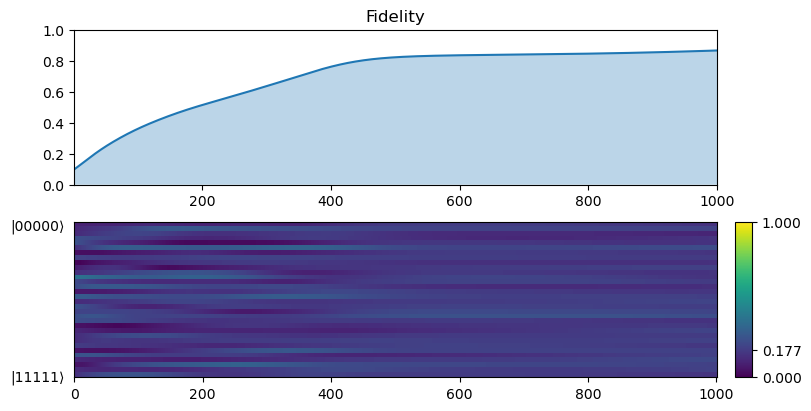

In [256]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

n_train_qubits = 8

batch_size = 8

num_epochs = 1001

learning_rate = 1e-3

n_qft_qubits = 5
N = 2**n_qft_qubits

loss_graph = []

q_graph = np.zeros((2**n_qft_qubits,num_epochs))


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(n_train_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            return x
        else:
            x = basis(q0) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
            x = x @ cz(2,3) @ cz(2,4)
            x = x @ cz(3,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            x = abs(x)
            for j in range(2**n_qft_qubits):
                q_graph[j][epoch] = x[j]
            
            
            x_out = []
            for a in batch:
                x = basis(a) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ cz(1,2) @ cz(1,3) @ cz(1,4)
                x = x @ cz(2,3) @ cz(2,4)
                x = x @ cz(3,4)
                x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
                x_out.append(x)
                
            return torch.stack(x_out)

#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_qft_qubits], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(32), 1])

axis_ones = ""
for i in range(n_qft_qubits):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_qft_qubits):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_qft_qubits - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

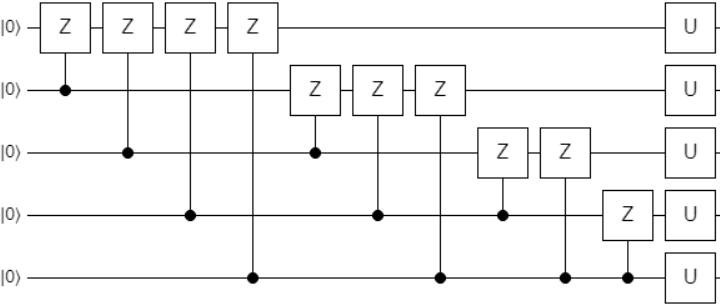

array([[0.14596526, 0.29079484, 0.05902865, 0.22126247, 0.03406835,
        0.1771541 , 0.14488374, 0.27687975, 0.04393377, 0.21739207,
        0.12707213, 0.23278486, 0.10638163, 0.26561667, 0.07257796,
        0.219893  , 0.07160461, 0.2391897 , 0.12915996, 0.18664111,
        0.15280183, 0.23889031, 0.0792769 , 0.22218765, 0.08826526,
        0.22608484, 0.10346621, 0.17603696, 0.12901543, 0.17522563,
        0.06459349, 0.23330617],
       [0.2101198 , 0.26234636, 0.15296851, 0.19937623, 0.0663433 ,
        0.08532936, 0.20711505, 0.25855728, 0.13931474, 0.16528039,
        0.17904255, 0.2254678 , 0.19751381, 0.27593079, 0.17856507,
        0.17159872, 0.11376694, 0.20424943, 0.11026463, 0.10765044,
        0.16790518, 0.21570381, 0.10278286, 0.18613997, 0.10980627,
        0.19996351, 0.20156026, 0.16966029, 0.05324789, 0.11719562,
        0.10831327, 0.21965258],
       [0.16642992, 0.22248064, 0.07123515, 0.17026775, 0.10439011,
        0.20155873, 0.17185411, 0.217222  , 0.1040

epoch: 0, loss: 0.9796112815323614
epoch: 500, loss: 0.006579418438311488
epoch: 1000, loss: 1.958008394617461e-05
tensor([0.1770+1.0408e-17j, 0.1764-9.3009e-05j, 0.1769-3.4032e-04j,
        0.1763+4.2471e-05j, 0.1769-2.5811e-04j, 0.1768+4.0262e-04j,
        0.1769-5.1080e-04j, 0.1763+3.9623e-04j, 0.1767+2.1892e-03j,
        0.1771+1.7539e-03j, 0.1768+1.8900e-03j, 0.1766+1.8102e-03j,
        0.1769+2.4206e-03j, 0.1768+1.2973e-03j, 0.1768+2.1016e-03j,
        0.1766+1.3758e-03j, 0.1766+1.3951e-03j, 0.1765+1.5054e-03j,
        0.1761+1.8655e-03j, 0.1768+2.0732e-03j, 0.1763+1.2147e-03j,
        0.1772+1.7739e-03j, 0.1760+1.6371e-03j, 0.1771+2.5054e-03j,
        0.1772-8.0780e-05j, 0.1773-2.8102e-04j, 0.1769+3.3622e-04j,
        0.1772+4.7363e-04j, 0.1776+9.2217e-05j, 0.1765-5.2229e-04j,
        0.1771+5.7282e-04j, 0.1769+1.7580e-06j], dtype=torch.complex128,
       grad_fn=<MulBackward0>)


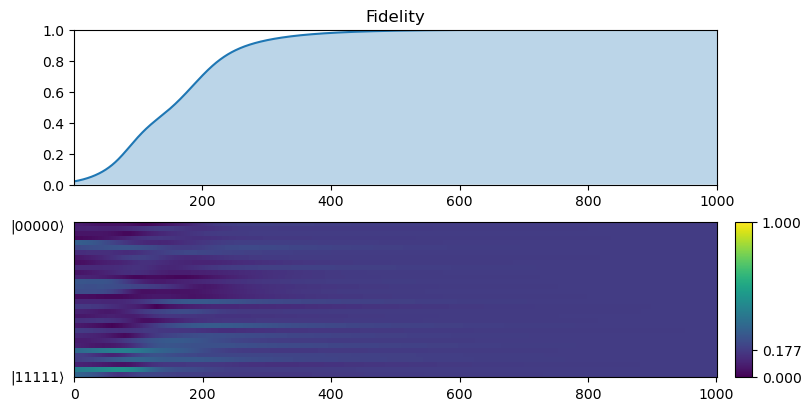

In [96]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

n_train_qubits = 8

batch_size = 8

num_epochs = 1001

learning_rate = 1e-3

n_qft_qubits = 5
N = 2**n_qft_qubits

loss_graph = []

q_graph = np.zeros((2**n_qft_qubits,num_epochs))

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(n_train_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,6), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            return x
        else:
            x = basis(q0) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
            x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
            x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
            x = abs(x)
            for j in range(2**n_qft_qubits):
                q_graph[j][epoch] = x[j]
            
            
            x_out = []
            for a in batch:
                x = basis(a) @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,0) @ U(1,0) @ U(2,0) @ U(3,0) @ U(4,0)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,1) @ U(1,1) @ U(2,1) @ U(3,1) @ U(4,1)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,2) @ U(1,2) @ U(2,2) @ U(3,2) @ U(4,2)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,3) @ U(1,3) @ U(2,3) @ U(3,3) @ U(4,3)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,4) @ U(1,4) @ U(2,4) @ U(3,4) @ U(4,4)
                x = x @ cz(0,1) @ cz(0,2) @ cz(0,3) @ cz(0,4)
                x = x @ U(0,5) @ U(1,5) @ U(2,5) @ U(3,5) @ U(4,5)
                x_out.append(x)
                
            return torch.stack(x_out)

#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss
#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_qft_qubits], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(32), 1])

axis_ones = ""
for i in range(n_qft_qubits):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_qft_qubits):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_qft_qubits - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

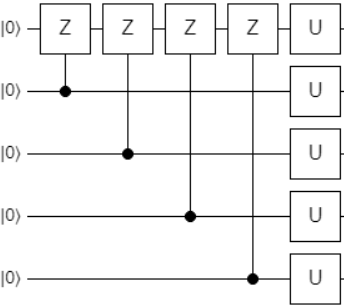

epoch: 0, loss: 0.8254422269830846
epoch: 500, loss: 0.04052229478105271
tensor([0.3464+1.3878e-17j, 0.3580+3.4243e-03j, 0.3491-4.0678e-04j,
        0.3581+2.4582e-03j, 0.3476-9.6856e-04j, 0.3607+3.4398e-03j,
        0.3477+5.2575e-04j, 0.3603+3.0776e-03j], dtype=torch.complex128,
       grad_fn=<MulBackward0>)


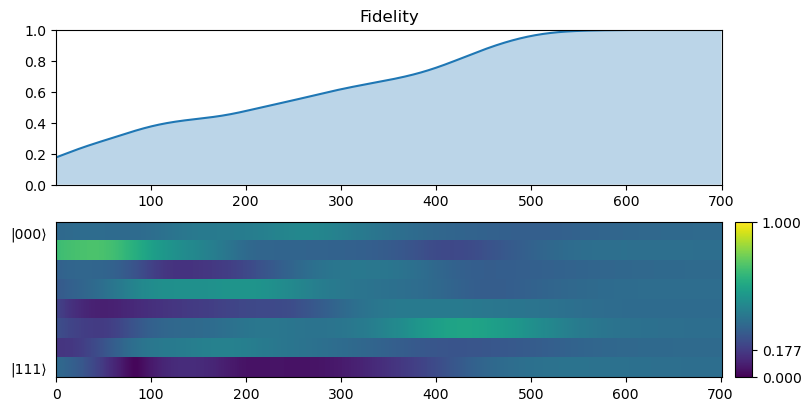

In [169]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

num_epochs = 701

learning_rate = 1e-3

num_layers = 8

n_qft_qubits = 3

N = 2**n_qft_qubits
n_train_qubits = N

batch_size = N

loss_graph = []

q_graph = np.zeros((2**n_qft_qubits,num_epochs))


c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n_qft_qubits
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        self.dataset = torch.eye(n_train_qubits, dtype=torch.complex128)
        labels = []

        for i in range(n_train_qubits):
            labels.append(F @ self.dataset[i])
            
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x)
            for layer in range(num_layers):
                for a in range(n_qft_qubits-1):
                    x = cz(0,a+1) @ x
                for b in range(n_qft_qubits):
                    x = U(b,layer) @ x
            return x
        else:
            x_out = []
            for x in batch:
                for layer in range(num_layers):
                    for a in range(n_qft_qubits-1):
                        x = cz(0,a+1) @ x
                    for b in range(n_qft_qubits):
                        x = U(b,layer) @ x
                x_out.append(x)
                x_graph = abs(x)
                
            for i in range(2**n_qft_qubits):
                q_graph[i][epoch] = x_graph[i]
            
                
            return torch.stack(x_out)
#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        

model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = plt.imshow(q_graph,norm=norm, origin = 'upper',  extent = [0, num_epochs, 0, 2**n_qft_qubits], aspect = 'auto', interpolation='none')
cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(N), 1])

axis_ones = ""
for i in range(n_qft_qubits):
    axis_ones = "1" + axis_ones
axis_zeros = ""
for i in range(n_qft_qubits):
    axis_zeros = "0" + axis_zeros

ax2.set_yticks([0.5,2**n_qft_qubits - 0.5], labels=[f'|{axis_ones}⟩',f'|{axis_zeros}⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

In [170]:
new_basis = torch.eye(N)
new_out = model(new_basis)
print(new_out)
for i in range(len(new_out)):
    fake_global_phase = torch.angle(new_out[i][0])
    new_out[i] = torch.exp(-1j * fake_global_phase) * new_out[i]
new_out = new_out.detach().numpy()

tensor([[ 0.3320-0.0989j,  0.3441-0.0989j,  0.3345-0.1000j,  0.3439-0.0999j,
          0.3329-0.1001j,  0.3467-0.0997j,  0.3334-0.0987j,  0.3462-0.0999j],
        [-0.3593-0.0300j, -0.2235-0.2645j,  0.0317-0.3612j,  0.2626-0.2236j,
          0.3595+0.0290j,  0.2220+0.2620j, -0.0290+0.3589j, -0.2665+0.2256j],
        [-0.3235+0.1225j, -0.1242-0.3372j,  0.3228-0.1221j,  0.1253+0.3414j,
         -0.3237+0.1235j, -0.1250-0.3399j,  0.3226-0.1235j,  0.1248+0.3373j],
        [-0.3580-0.0323j,  0.2672-0.2235j, -0.0304+0.3582j, -0.2216-0.2686j,
          0.3576+0.0324j, -0.2672+0.2205j,  0.0317-0.3591j,  0.2209+0.2670j],
        [-0.3514+0.0808j,  0.3389-0.0762j, -0.3511+0.0805j,  0.3410-0.0735j,
         -0.3478+0.0790j,  0.3412-0.0731j, -0.3507+0.0803j,  0.3375-0.0749j],
        [-0.3384-0.0749j,  0.1938+0.3051j,  0.0742-0.3358j, -0.3046+0.1921j,
          0.3375+0.0772j, -0.1943-0.3039j, -0.0754+0.3388j,  0.3050-0.1943j],
        [ 0.2672-0.2441j, -0.2290-0.2590j, -0.2672+0.2420j,  0.2303+0.

In [171]:
def hinton_square(x,y,U_angle,U_angle_min, U_angle_max,area,cmap=None,ax=None):
    
    h = np.sqrt(area) / 2
    color = (U_angle - U_angle_min) / (U_angle_max - U_angle_min)
    
    x = np.array([x - h, x + h, x + h, x - h])
    y = np.array([y - h, y - h, y + h, y + h])
    
    plt.fill(x,y, color=cmap(color))

In [172]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def hinton(U):
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))
    
    height, width = U.shape
    
    ax.axis('equal')
    ax.set_frame_on(False)
    plt.xlim(0,width)
    plt.ylim(0,height)

    U_max = np.max(np.abs(U))
    
    cmap = plt.get_cmap('twilight')
    scale = 0.75

    
    for i in range(width):
        for j in range(height):
            x = i + 0.5
            y = j + 0.5
            hinton_square(x, height - y, np.angle(U[i,j]), -np.pi, np.pi, 
                          np.abs(U[i,j]) / U_max * scale, cmap=cmap, ax=ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '4%', pad = '2%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(-np.pi, np.pi),
                                     ticks = [])

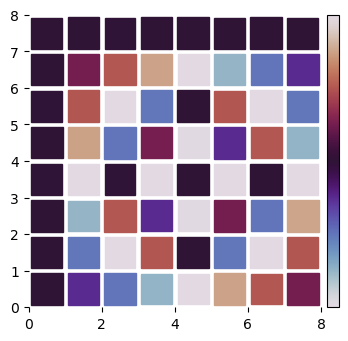

In [173]:
hinton(new_out)

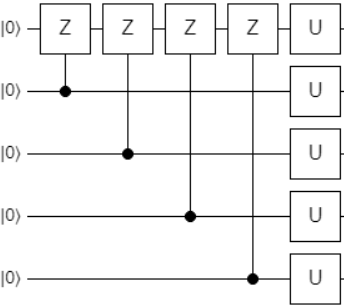

In [199]:
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

num_epochs = 701

learning_rate = 1e-3

num_layers = 8

n_qft_qubits = 3

N = 2**n_qft_qubits
n_train_qubits = N

batch_size = N

loss_graph = []

c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n_qft_qubits
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        self.dataset = torch.eye(n_train_qubits, dtype=torch.complex128)
        labels = []

        for i in range(n_train_qubits):
            labels.append(F @ self.dataset[i])
            
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x)
            for layer in range(num_layers):
                for a in range(n_qft_qubits-1):
                    x = cz(0,a+1) @ x
                for b in range(n_qft_qubits):
                    x = U(b,layer) @ x
            return x
        else:
            x_out = []
            for x in batch:
                for layer in range(num_layers):
                    for a in range(n_qft_qubits-1):
                        x = cz(0,a+1) @ x
                    for b in range(n_qft_qubits):
                        x = U(b,layer) @ x
                x_out.append(x)
                x_graph = abs(x)
    
            return torch.stack(x_out)
#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

def hinton_square(x,y,U_angle,U_angle_min, U_angle_max,area,cmap=None,ax=None):
    
    h = np.sqrt(area) / 2
    color = (U_angle - U_angle_min) / (U_angle_max - U_angle_min)
    
    x = np.array([x - h, x + h, x + h, x - h])
    y = np.array([y - h, y - h, y + h, y + h])
    
    plt.fill(x,y, color=cmap(color))

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def hinton(U):
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))
    
    height, width = U.shape
    
    ax.axis('equal')
    ax.set_frame_on(False)
    plt.xlim(0,width)
    plt.ylim(0,height)

    U_max = np.max(np.abs(U))
    
    cmap = plt.get_cmap('twilight')
    scale = 0.75

    
    for i in range(width):
        for j in range(height):
            x = i + 0.5
            y = j + 0.5
            hinton_square(x, height - y, np.angle(U[i,j]), -np.pi, np.pi, 
                          np.abs(U[i,j]) / U_max * scale, cmap=cmap, ax=ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '4%', pad = '2%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(-np.pi, np.pi),
                                     ticks = [])

hinton(new_out)



model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
        new_basis = torch.eye(N)
        new_out = model(new_basis)
        print(new_out)
for i in range(len(new_out)):
    fake_global_phase = torch.angle(new_out[i][0])
    new_out[i] = torch.exp(-1j * fake_global_phase) * new_out[i]
new_out = new_out.detach().numpy()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        

model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

epoch: 0, loss: 0.692253306342101
epoch: 500, loss: 6.6601613113448366e-09
tensor([0.4999-2.7756e-17j, 0.5000+2.6992e-06j, 0.5000-1.9431e-05j,
        0.5000-8.2359e-06j], dtype=torch.complex128, grad_fn=<MulBackward0>)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

epoch: 0, loss: 0.7056353179469403
tensor([ 0.4501-1.1102e-16j, -0.1504-7.7246e-01j, -0.0271-2.4895e-01j,
         0.2019-2.7312e-01j], dtype=torch.complex128, grad_fn=<MulBackward0>)


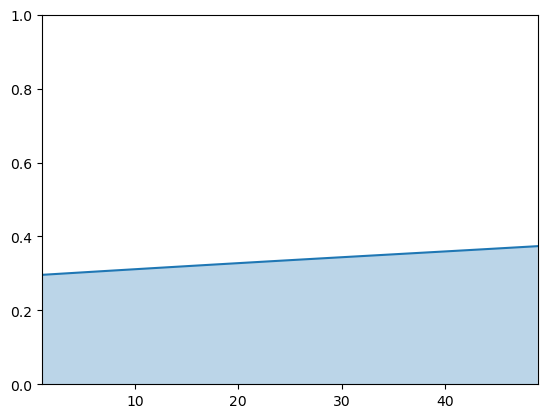

In [62]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

num_epochs = 50

learning_rate = 1e-3

num_layers = 4

n_qft_qubits = 2

N = 2**n_qft_qubits
n_train_qubits = N

batch_size = N

loss_graph = []

hinton_anim = []

artists = []

c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n_qft_qubits
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        self.dataset = torch.eye(n_train_qubits, dtype=torch.complex128)
        labels = []

        for i in range(n_train_qubits):
            labels.append(F @ self.dataset[i])
            
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x)
            for layer in range(num_layers):
                for a in range(n_qft_qubits-1):
                    x = cz(0,a+1) @ x
                for b in range(n_qft_qubits):
                    x = U(b,layer) @ x
            return x
        else:
            x_out = []
            for x in batch:
                for layer in range(num_layers):
                    for a in range(n_qft_qubits-1):
                        x = cz(0,a+1) @ x
                    for b in range(n_qft_qubits):
                        x = U(b,layer) @ x
                x_out.append(x)
                x_graph = abs(x)
    
            return torch.stack(x_out)
#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
        new_basis = torch.eye(N, requires_grad=False)
        new_out = model(new_basis)
        for i in range(len(new_out)):
            fake_global_phase = torch.angle(new_out[i][0])
            new_out[i] = torch.exp(-1j * fake_global_phase) * new_out[i]
        new_out = new_out.detach().numpy()
        
        hinton_anim.append(new_out)
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        

model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(q_out)

#===============================================================================================================================

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

# plt.set_title('Fidelity')
plt.ylim(0,1)
plt.xlim(1,num_epochs * n_train_qubits / batch_size - 1)
plt.plot(x_graph,loss_graph)
plt.fill_between(x_graph, loss_graph, alpha=0.3)

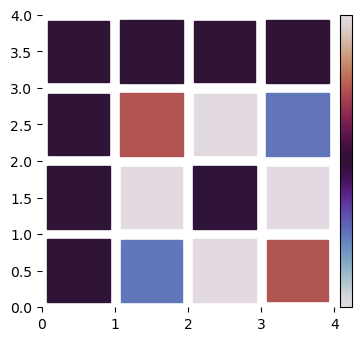

layers: 10, epoch: 0, loss: 0.8072707795646791
layers: 10, epoch: 100, loss: 0.11359891989862864
layers: 10, epoch: 200, loss: 0.0009941037017872911
layers: 10, epoch: 300, loss: 2.4302824822020064e-07
layers: 10, epoch: 400, loss: 3.6260439095769925e-12
layers: 10, epoch: 500, loss: 2.7755575615628914e-16
0:00:39.127246
without global phase: tensor([0.5000+5.5511e-17j, 0.5000+1.2356e-08j, 0.5000+1.2834e-08j,
        0.5000+1.3151e-08j], dtype=torch.complex128, grad_fn=<MulBackward0>)
new_out:[[ 5.00000002e-01+5.55111512e-17j  5.00000009e-01+1.23563624e-08j
   4.99999998e-01+1.28339018e-08j  4.99999992e-01+1.31507427e-08j]
 [ 5.00000003e-01-1.21430643e-17j -4.99498923e-09+4.99999991e-01j
  -4.99999998e-01-1.30790804e-08j -3.03361526e-09-5.00000008e-01j]
 [ 5.00000002e-01+2.77555756e-17j -4.99999996e-01-9.06164974e-09j
   4.99999998e-01-1.14089211e-08j -5.00000004e-01+7.79736761e-09j]
 [ 4.99999993e-01+2.77555756e-17j -7.36788705e-09-5.00000005e-01j
  -5.00000006e-01+1.16540997e-08j  1.

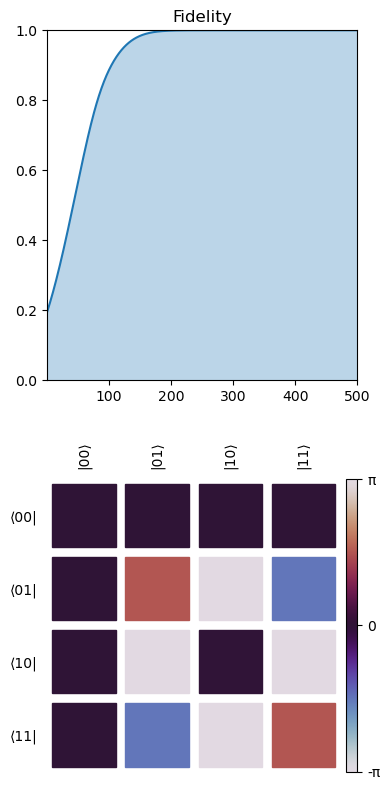

In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from datetime import datetime
startTime = datetime.now()

num_epochs = 501

learning_rate = 1e-3

num_layers = 10

n_qft_qubits = 2

N = 2**n_qft_qubits
n_train_qubits = N

batch_size = N

loss_graph = []

torch.set_default_device('cpu')

c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n_qft_qubits
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        self.dataset = torch.eye(N, dtype=torch.complex128)

        labels = []

        for i in range(n_train_qubits):
            labels.append(F @ self.dataset[i])
            
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

# data_set = input_vec_dataset()

# data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x)
            for layer in range(num_layers):
                for i in range(n_qft_qubits-1):
                    for a in range(n_qft_qubits-1-i):
                        x = cz(0+i,a+i+1) @ x
                for b in range(n_qft_qubits):
                    x = U(b,layer) @ x
            return x
        else:
            x_out = []
            for x in batch:
                for layer in range(num_layers):
                    for a in range(n_qft_qubits-1):
                        x = cz(0,a+1) @ x
                    for b in range(n_qft_qubits):
                        x = U(b,layer) @ x
                x_out.append(x)
                x_graph = abs(x)

            return torch.stack(x_out)
#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

def test_model():

    global num_layers
    global model
    global loss_graph
    global n_qft_qubits
    global N
    global batch
    
    data_set = input_vec_dataset()

    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)
    
    loss_graph = []
    
    model = QFTmodel()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):

        for batch, labels in data_loader:

            optimizer.zero_grad()

            outputs = model(batch)

            loss = quantum_infidelity_batched(outputs, labels) 

            loss.backward()

            optimizer.step()

        if epoch % 100 == 0:

            print(f'layers: {num_layers}, epoch: {epoch}, loss: {loss}')
            
    if loss > 0.01:
        num_layers += 1
        test_model()
#===============================================================================================================================        

test_model()

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (4,10))

def hinton_labels(n_qft_qubits):
    basis_labels = [format(i, 'b').zfill(n_qft_qubits) for i in range(N)]
    kets = [f'|{l}⟩' for l in basis_labels]
    bras = [f'⟨{l}|' for l in basis_labels]
    return [kets, bras]

def hinton_square(x,y,U_angle,U_angle_min, U_angle_max,area,cmap=None,ax=None):

    h = np.sqrt(area) / 2
    color = (U_angle - U_angle_min) / (U_angle_max - U_angle_min)
    x = np.array([x - h, x + h, x + h, x - h])
    y = np.array([y - h, y - h, y + h, y + h])
    
    plt.fill(x,y, color=cmap(color))

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def hinton(U, xlabels=None,ylabels=None,ax=None):
    
    height, width = U.shape
    
    ax.axis('equal')
    ax.set_frame_on(False)
    ax.set_xlim(0,width)
    ax.set_ylim(0,height)

    U_max = np.max(np.abs(U))
    
    cmap = plt.get_cmap('twilight')
    scale = 0.75
    
    for i in range(width):
        for j in range(height):
            x = i + 0.5
            y = j + 0.5
            hinton_square(x, height - y, np.angle(U[i,j]), -np.pi, np.pi, 
                          np.abs(U[i,j]) / U_max * scale, cmap=cmap, ax=ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '4%', pad = '2%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(-np.pi, np.pi),
                                     ticks = [-np.pi,0,np.pi])
    cbar.ax.set_yticklabels(['-π', '0', 'π'])
    
    ax.xaxis.set_ticks(np.arange(0.5,N))
    ax.set_xticklabels(xlabels, rotation = 'vertical')
    ax.xaxis.tick_top()
    
    ax.yaxis.set_ticks(np.arange(0.5,N))
    ax.set_yticklabels(ylabels)
    ax.set_yticklabels(list(reversed(ylabels)))
    
    ax.tick_params(axis='both', labelsize=10)
    ax.tick_params(left=False,top=False)   
    
#===============================================================================================================================    

print(datetime.now() - startTime)

model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

fake_global_phase = torch.angle(q_out[0])
q_out = torch.exp(-1j * fake_global_phase) * q_out
print(f'without global phase: {q_out}')

new_basis = torch.eye(N, requires_grad=False)
new_out = model(new_basis)
for i in range(len(new_out)):
    fake_global_phase = torch.angle(new_out[i][0])
    new_out[i] = torch.exp(-1j * fake_global_phase) * new_out[i]
new_out = new_out.detach().numpy()

kets, bras = hinton_labels(n_qft_qubits)
hinton(new_out, xlabels=kets, ylabels=bras, ax=ax2)
print(f'new_out:{new_out}')

#===============================================================================================================================

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

epoch: 0, loss: 0.8444608032691703
epoch: 10, loss: 0.4903495890339685
epoch: 20, loss: 0.05246710369416063
length=1: tensor([-0.1511+0.4770j, -0.1460+0.4513j, -0.1655+0.4574j, -0.1534+0.5143j],
       dtype=torch.complex128)
without global phase:tensor([0.5004+2.7756e-17j, 0.4743+2.8528e-03j, 0.4860+1.9685e-02j,
        0.5366-9.0465e-03j], dtype=torch.complex128)
tensor([[-0.3025+0.3952j,  0.4064+0.3391j,  0.3231-0.3767j, -0.3628-0.3069j]],
       dtype=torch.complex128)
tensor([[0.4977+8.3267e-17j, 0.5293+0.0000e+00j, 0.4963+2.7756e-17j,
         0.4752+1.1102e-16j]], dtype=torch.complex128)


AttributeError: 'list' object has no attribute 'detach'

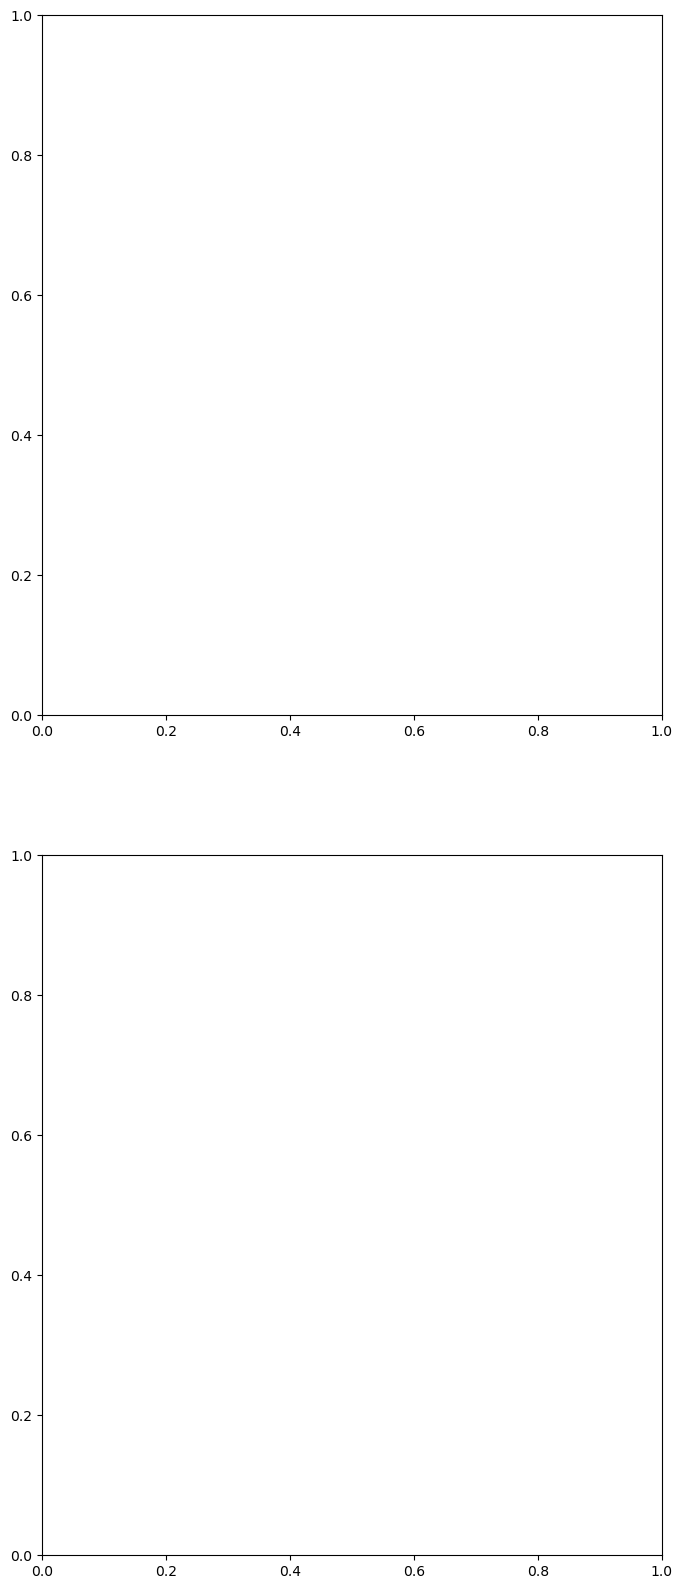

In [23]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

num_epochs = 30

learning_rate = 1e-3

num_layers = 20

n_qft_qubits = 2

N = 2**n_qft_qubits
n_train_qubits = N

batch_size = 1

loss_graph = []

c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n_qft_qubits
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        self.dataset = torch.eye(n_train_qubits, dtype=torch.complex128)
        labels = []

        for i in range(n_train_qubits):
            labels.append(F @ self.dataset[i])
            
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================

class QFTmodel(torch.nn.Module):
    
    def __init__(self):
        super(QFTmodel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand((n_qft_qubits,num_layers), dtype=torch.float64))
    
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        q0 = torch.tensor([1,0], dtype=torch.complex128)
        q1 = torch.tensor([0,1], dtype=torch.complex128)

        i_gate = torch.tensor([[1,0],
                               [0,1]], dtype=torch.complex128)
        z_gate = torch.tensor([[1,0],
                               [0,-1]], dtype=torch.complex128)
        
        def basis(*args):
            basis = []
            for j in range(n_qft_qubits):
                basis.append(q0)
                
            for j in args:
                basis[0] = j
            
            a = basis[0]
            for j in range(len(basis)-1):
                a = torch.kron(a,basis[j+1])
            return a

        def U(target,nth_gate):
            U = [i_gate for _ in range(n_qft_qubits)]
            U[target] = elements_to_matrix(
                        [[torch.exp(1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate]), 
                          torch.exp(1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate])],
                         [- torch.exp(-1j * β[target][nth_gate]) * torch.sin(θ[target][nth_gate]), 
                          torch.exp(-1j * α[target][nth_gate]) * torch.cos(θ[target][nth_gate])]])
            a = U[0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,U[j+1])
            return a

        def cz(control,target):
            zeros = torch.outer(q0,q0)
            ones = torch.outer(q1,q1)

            cz = [[i_gate for _ in range(n_qft_qubits)] for _ in range(2)]

            cz[0][control] = zeros

            cz[1][control] = ones
            cz[1][target] = z_gate

            a = cz[0][0]

            for j in range(n_qft_qubits-1):
                a = torch.kron(a,cz[0][j+1])

            b = cz[1][0]

            for j in range(n_qft_qubits-1):
                b = torch.kron(b,cz[1][j+1])
            return a + b

        if len(x.shape) == 1:
            x = basis(x)
            for layer in range(num_layers):
                for i in range(n_qft_qubits-1):
                    for a in range(n_qft_qubits-1-i):
                        x = cz(0+i,a+i+1) @ x
                for b in range(n_qft_qubits):
                    x = U(b,layer) @ x
            print(f'length=1: {x}')
            return x
        else:
            x_out = []
            for x in batch:
                for layer in range(num_layers):
                    for i in range(n_qft_qubits-1):
                        for a in range(n_qft_qubits-1-i):
                            x = cz(0+i,a+i+1) @ x
                    for b in range(n_qft_qubits):
                        x = U(b,layer) @ x
                x_out.append(x)
                x_graph = abs(x)

            return torch.stack(x_out)
#===============================================================================================================================

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================

model = QFTmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 10 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')

#===============================================================================================================================        

fig, (ax1,ax2) = plt.subplots(2,1, figsize = (8,20))

def hinton_labels(n_qft_qubits):
    basis_labels = [format(i, 'b').zfill(n_qft_qubits) for i in range(N)]
    kets = [f'|{l}⟩' for l in basis_labels]
    bras = [f'⟨{l}|' for l in basis_labels]
    return [kets, bras]

def hinton_square(x,y,U_angle,U_angle_min, U_angle_max,area,cmap=None,ax=None):

    h = np.sqrt(area) / 2
    color = (U_angle - U_angle_min) / (U_angle_max - U_angle_min)
    x = np.array([x - h, x + h, x + h, x - h])
    y = np.array([y - h, y - h, y + h, y + h])
    
    plt.fill(x,y, color=cmap(color))

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def hinton(U, xlabels=None,ylabels=None,ax=None):
    
    height, width = U.shape
    
    ax.axis('equal')
    ax.set_frame_on(False)
    ax.set_xlim(0,width)
    ax.set_ylim(0,height)

    U_max = np.max(np.abs(U))
    
    cmap = plt.get_cmap('twilight')
    scale = 0.75
    
    for i in range(width):
        for j in range(height):
            x = i + 0.5
            y = j + 0.5
            hinton_square(x, height - y, np.angle(U[i,j]), -np.pi, np.pi, 
                          np.abs(U[i,j]) / U_max * scale, cmap=cmap, ax=ax)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size = '4%', pad = '2%')
    cbar = mpl.colorbar.ColorbarBase(cax, cmap = cmap,
                                     norm = mpl.colors.Normalize(-np.pi, np.pi),
                                     ticks = [-np.pi,0,np.pi])
    cbar.ax.set_yticklabels(['-π', '0', 'π'])
    
    ax.xaxis.set_ticks(np.arange(0.5,N))
    ax.set_xticklabels(xlabels, rotation = 'vertical')
    ax.xaxis.tick_top()
    
    ax.yaxis.set_ticks(np.arange(0.5,N))
    ax.set_yticklabels(ylabels)
    ax.set_yticklabels(list(reversed(ylabels)))
    
    ax.tick_params(axis='both', labelsize=4)
    ax.tick_params(left=False,top=False)   
    
#===============================================================================================================================    
    
with torch.no_grad():

    q_test = torch.tensor([1,0], dtype=torch.complex128)

    q_out = model(q_test)

    fake_global_phase = torch.angle(q_out[0])
    q_out = torch.exp(-1j * fake_global_phase) * q_out
    print(f'without global phase:{q_out}')

    new_basis = torch.eye(N, requires_grad=False)
#     new_basis_out = []
    new_out = model(new_basis)
    print(new_out)
    fake_global_phase = torch.angle(new_out[0])
    new_out = torch.exp(-1j * fake_global_phase) * new_out
    new_basis_out.append(new_out)
#     print(new_out)
#     new_basis_out = torch.stack(new_basis_out).squeeze()
#     new_basis_out = new_basis_out.detach().numpy()

    kets, bras = hinton_labels(n_qft_qubits)
    hinton(new_basis_out, xlabels=kets, ylabels=bras, ax=ax2)
    print(f'new_out:{new_basis_out}')

#===============================================================================================================================

x_graph = np.arange(num_epochs * n_train_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_train_qubits / batch_size))

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_train_qubits / batch_size - 1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

In [1]:
import numpy as np

In [2]:
a = [1,2,3,4]

In [11]:
print(f'hi \n{a}')

hi 
[1, 2, 3, 4]
